# **Pipelines of steps and results of immidiately performed steps**

In [1]:
from keras.preprocessing import sequence
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np

## Data Loading and Preprocessing

### **Flowchart for data preprocessing**
<div style="text-align:'center';">
    <center><img src="./flowchart.png" width="500"/></center>
</div>

### **Explanation**
In this particular process we need to firstly load the data. The data is downloaded locally and is put in path *'/charaNet'*. This dataset was downloaded from Kaggle and it's source is linked at the end of this paper.

We defined three directories, each for test, train and validation set that has already been pre-defined from the data source. In this each of the folder contain sub folders which have name of the bird for whose audio are inside the respective folder.

In the next step we define a function that will assist us to load and preprocess the data. Preprocessing data is important for two reasons:
1. The data is in audio format but we want it to have it so that data is in digital formats or in numbers.
2. The data is also required to be padded so that it is of same length across our training model. This is important since the dimension (in this case length) of data should always be same.

#### Step 1
First we check what the maximun audio sampling rate (in Hertz) is for all the files since some may have lower sampling rate. Also we check the duration of each of the file. This will be checked for input file and the max data will be taken so that we can perform padding. This is done using a library called `librosa`. In this case instead creating the entire function we just simply loop through all the data in the training folder. And we use `mathplotlib` library to show the frequency vs sample or duration of the data and label the maximum value so that we can set this as our data constants.

#### Step 2
The function, `load_data(data_dir)`, is designed to load audio data from a specified directory. It takes the directory path `data_dir` as input. Within this directory, the function expects subdirectories, each representing a category or class of audio data. The function iterates through these subdirectories, loading each audio file found within them using the librosa library. It pads the audio data to ensure uniform length as we will have figured out the sample rate and duration that is ideal for uniformity accross the dataset. The loaded audio data is appended to a list `X`, while corresponding labels are assigned based on the folder name and appended to a separate list `y`. Finally, it returns `X` and `y` as numpy arrays, where `X` contains the audio data and `y` contains the corresponding labels. Overall, this function facilitates the preprocessing and organization of audio data for machine learning tasks such as classification.

In [8]:

# Define the path to your data directory
input_dir = './charaNet/train'
test_dir = './charaNet/test'
val_dir = './charaNet/val'

## Figuring out necessary padding to make dataset uniform and perform normalization
We loop through the data to load the data in `librosa` and use it to figure out the sample rate of the audio data, from this we can also calculate the duration. 

### Plot the highest occurrence of data
Using `Matplot` library we plot the occurance of sampling rate and duration and check the samples that have the highest values and pad the data in `librosa` library accordingly. This will help us maintain the same number of dimension in our data. It is one of the fundamentals for Neural Network models to have uniformity in the input data.

In [9]:
import matplotlib.pyplot as plt

# Initialize an empty array to store audio files with unique sampling rates
sampling_rate = []
sampling_duration = []

# Loop through the files in the directory
for dirname in os.listdir(input_dir):
    subpath = os.path.join(input_dir, dirname)
    if os.path.isdir(subpath):
        for filename in os.listdir(subpath):
            filepath = os.path.join(subpath,filename)
            if os.path.isfile(filepath) and filename.endswith('.mp3'):
                # Load the audio file and get its sampling rate
                audio, sr = librosa.load(filepath, sr=None)
                sampling_rate.append(sr)
                duration = librosa.get_duration(y=audio, sr=sr)
                sampling_duration.append(duration)

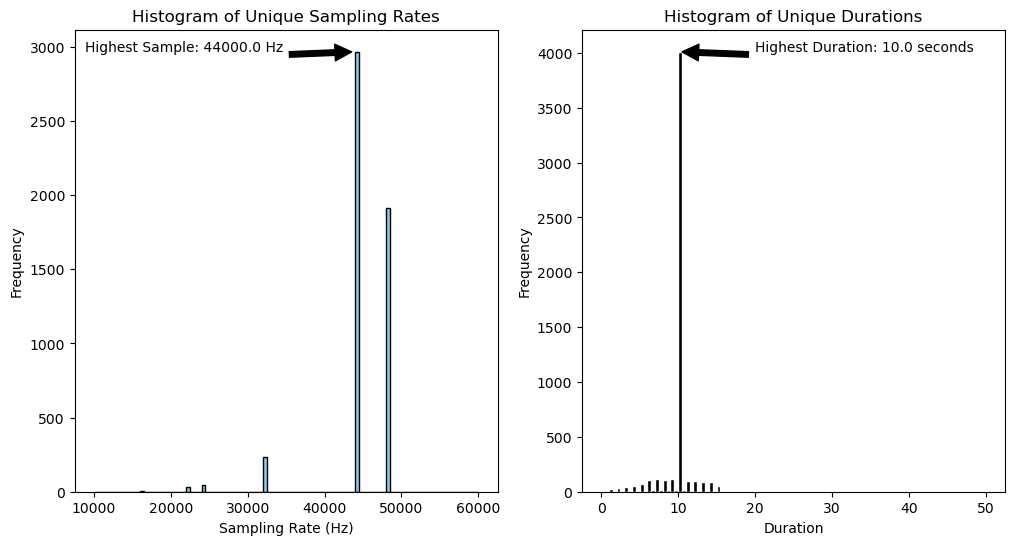

In [4]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1,2,1)
n_sample, bins_sample, patches_sample = ax1.hist(sampling_rate, bins=100, color='skyblue', edgecolor='black',range=(10000,60000))
ax1.set_xlabel('Sampling Rate (Hz)')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of Unique Sampling Rates')

ax2 = plt.subplot(1,2,2)
n, bins, patches = ax2.hist(sampling_duration, bins=100, color='black', edgecolor='white',range=(0,50))
ax2.set_xlabel('Duration')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of Unique Durations')

# Find the bin with the highest frequency
max_freq_bin_sample = bins_sample[n_sample.argmax()]
max_freq_bin = bins[n.argmax()]

# Annotate the plot with the highest frequency
ax1.annotate(f'Highest Sample: {max_freq_bin_sample} Hz', xy=(max_freq_bin_sample, n_sample.max()), xytext=(max_freq_bin_sample/5, n_sample.max()), arrowprops=dict(facecolor='black', shrink=0.05))
ax2.annotate(f'Highest Duration: {max_freq_bin} seconds', xy=(max_freq_bin, n.max()), xytext=(max_freq_bin + 10, n.max()), arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

#### From the histograms we can see that the max sampling rate of the audio files is 44000 Hz 
So we set the sample as 44,000 Hz
#### Also from the histograms we can see that the highest frequency duration of the audio files is 10s
So we will reduce the duration such that we only have to compute for 10s.


In [10]:
# Define the sampling rate and duration of audio samples
sampling_rate = 44000
duration = 10  # Duration in seconds

## Conversion of Audio signal to Mel-spectrom

### Mel-Spectrogram
A spectrogram is a graphical representation of a signal that provides information about the presence of various frequency components at different times and their respective amplitudes. When we talk about Mel spectrograms, we are referring to spectrograms where the signal frequencies are transformed into the Mel scale, which is perceptually relevant in terms of frequency perception by humans.

The process of extracting a Mel spectrogram from an audio signal involves several steps:

1. **Short-Time Fourier Transform (STFT):** The audio signal is divided into short overlapping segments, and the Fourier Transform is applied to each segment to generate a standard spectrogram.

2. **Conversion to Decibel Scale:** The amplitudes of different frequencies in the spectrogram are converted to the decibel scale to represent them in a more perceptually meaningful way.

3. **Conversion to Mel Scale:** The frequencies in the spectrogram are then converted to the Mel scale, which mimics the nonlinear human perception of pitch. This conversion involves constructing a set of Mel filter banks:
   - **Choosing the Number of Mel Bands:** The number of Mel bands or filters in the filter bank is determined.
   - **Construction of Mel Filter Banks:** 
     - The lowest and highest frequencies of the spectrogram are converted to the Mel scale using a logarithmic equation.
     - The Mel scale frequency range is divided into equally spaced intervals called Mel bands, and the center frequency of each filter is positioned at the center of each interval.
     - The center frequencies of each filter are converted back to the Hertz scale and rounded to the nearest frequency bins.
     - For each filter, a bandpass filter (triangular filter) is designed to pass frequencies within a certain range around the center frequency.
   
4. **Application of Mel Filter Banks:** The constructed Mel filter banks are applied to the spectrogram resulting from the STFT. Each filter extracts information from specific frequency bands, and the outputs of these filters are summed to obtain the Mel spectrogram.

In summary, Mel spectrograms provide a perceptually relevant representation of audio signals by transforming their frequencies into the Mel scale, which better aligns with human auditory perception. This process involves applying the STFT, converting amplitudes to decibels, and using Mel filter banks to extract Mel spectrograms from the spectrogram.


In [12]:
# Function to load audio files and their corresponding labels
def load_data(data_dir,target_shape=(128, 860)):
    X = []  # List to store audio data
    y = []  # List to store corresponding labels
    
    # Iterate over the folders in your data directory
    for label, category in enumerate(os.listdir(data_dir)):
        category_dir = os.path.join(data_dir, category)
        
        # Check if it's a directory
        if os.path.isdir(category_dir):
            # Iterate over the files in the category directory
            for file in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file)
                
                # Load audio data using librosa
                audio_data, sr = librosa.load(file_path, sr=sampling_rate, duration=duration)
                
                # Pad audio data to ensure uniform length
                mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sr)

                # Ensure the spectrogram has the target shape
                if mel_spec.shape[1] < target_shape[1]:
                    mel_spec = np.pad(mel_spec, ((0, 0), (0, target_shape[1] - mel_spec.shape[1])), mode='constant')
                elif mel_spec.shape[1] > target_shape[1]:
                    mel_spec = mel_spec[:, :target_shape[1]]

                mel_spectrogram = librosa.power_to_db(mel_spec, ref=np.max)
                
                # Append the audio data to X
                X.append(mel_spectrogram)
                # Assign the label based on the folder name
                y.append(label)
    y = np.array(y)

    # Convert labels to one-hot encoded vectors
    num_classes = len(np.unique(y))
    y = to_categorical(y, num_classes=num_classes)
    return X, y

# Load data and labels
X_train_mel, y_train = load_data(input_dir)
X_test_mel, y_test = load_data(test_dir)
X_val_mel, y_val = load_data(val_dir)

IndexError: index 41 is out of bounds for axis 1 with size 41

### Audio sound for Asian Koel
Here we can see the audio of sound for Asian Koel bird

In [ ]:
from IPython.display import Audio 
from IPython.core.display import display

Sample_File = 3
count = 0
doBreak = False
audio_file_path = ""

for label, category in enumerate(os.listdir(input_dir)):
        if(doBreak):
             break
        category_dir = os.path.join(input_dir, category)
        # Check if it's a directory
        if os.path.isdir(category_dir):
            # Iterate over the files in the category directory
            for file in os.listdir(category_dir):
                file_path = os.path.join(category_dir, file)
                if(Sample_File == count):
                    audio_file_path = file_path
                    doBreak = True
                    break
                count+=1
                
if(audio_file_path!=""):
     display(Audio(file_path))


/var/folders/sb/rkhtj4gn34b_z3dmdhk0z3fc0000gn/T/ipykernel_275/3496064100.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


### Audio converted to Mel-Spectrogram also known as picture of sound

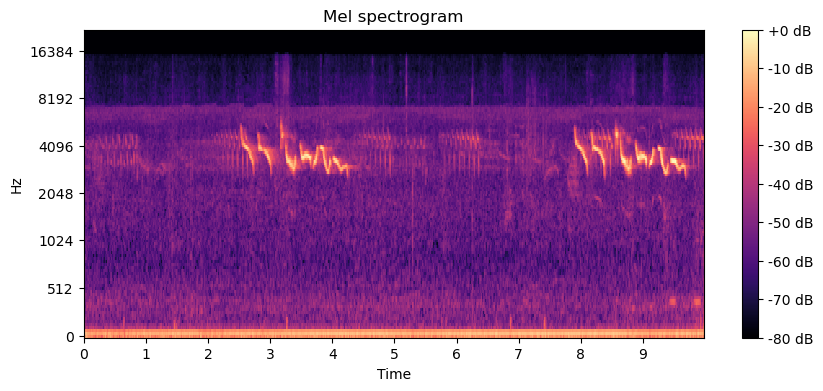

In [ ]:
# Plot Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(X_train_mel[Sample_File], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.show()

In [ ]:
X_train = np.array(X_train_mel)
X_test = np.array(X_test_mel)
X_val = np.array(X_val_mel)

In [ ]:
# Print shapes for verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (5407, 128, 860)
y_train shape: (5407, 41)
X_test shape: (687, 128, 860)
y_test shape: (687, 41)
X_val shape: (639, 128, 860)
y_val shape: (639, 41)


# **Model Training and Evaluation**

## Model Definition
This code segment utilizes the Keras library to construct a recurrent neural network (RNN) for classification. It initializes a sequential model with an LSTM layer comprising 128 units, considering each feature as a time step. The output layer consists of 41 units with a softmax activation function for class probability predictions. The model is compiled with the Adam optimizer and categorical cross-entropy loss function. It is then trained on training data (`X_train`, `y_train`) using a batch size of 32 for 100 epochs, with validation data (`X_val`, `y_val`) used for validation. Finally, the model's performance is evaluated on test data (`X_test`, `y_test`), and the test loss and accuracy are printed.


In [271]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the RNN model
model = Sequential()
model.add(LSTM(units=128, input_shape=(128, 860)))  # Assuming each feature is a time step, adjust input_shape accordingly
model.add(Dense(units=41, activation='softmax'))  # Adjust units to match the number of classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss: {s} , Test Accuracy: {s}", loss,accuracy)


2024-02-25 23:51:01.774023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-25 23:51:01.775085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-25 23:51:01.776001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-02-25 23:51:09.664921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-25 23:51:09.666554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-25 23:51:09.667248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

169/169 [==============================] - ETA: 0s - loss: 3.3694 - accuracy: 0.0679

2024-02-25 23:51:18.338353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-25 23:51:18.339505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-25 23:51:18.340021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

169/169 [==============================] - 10s 47ms/step - loss: 3.3694 - accuracy: 0.0679 - val_loss: 3.2348 - val_accuracy: 0.0642
Epoch 2/100
169/169 [==============================] - 6s 34ms/step - loss: 3.3042 - accuracy: 0.0688 - val_loss: 3.2091 - val_accuracy: 0.0814
Epoch 3/100
169/169 [==============================] - 7s 40ms/step - loss: 3.3032 - accuracy: 0.0732 - val_loss: 3.2062 - val_accuracy: 0.0814
Epoch 4/100
169/169 [==============================] - 7s 40ms/step - loss: 3.3014 - accuracy: 0.0756 - val_loss: 3.2074 - val_accuracy: 0.0736
Epoch 5/100
169/169 [==============================] - 6s 37ms/step - loss: 3.3030 - accuracy: 0.0734 - val_loss: 3.2093 - val_accuracy: 0.0814
Epoch 6/100
169/169 [==============================] - 6s 37ms/step - loss: 3.3019 - accuracy: 0.0760 - val_loss: 3.2055 - val_accuracy: 0.0814
Epoch 7/100
169/169 [==============================] - 6s 35ms/step - loss: 3.3013 - accuracy: 0.0668 - val_loss: 3.2111 - val_accuracy: 0.0814
Epo


## Output Analysis
The output shows the training progress of a neural network model across multiple epochs. Each epoch represents a complete pass through the entire training dataset. During training, the model's performance is evaluated on both the training data and a separate validation dataset after each epoch to monitor its learning progress and potential overfitting.

## Observations

1. The loss and accuracy metrics are displayed for both the training set and the validation set after each epoch.
2. Loss represents the error between the actual and predicted values, while accuracy indicates the proportion of correctly classified instances.
3. In this it is observed that the training **loss (3.3694)** and **accuracy (0.0679)** at the beginning of training are not very favorable. As training progresses, the loss decreases, and accuracy improves slightly. However, the improvements are not substantial, indicating that the model may not be learning effectively.
4. Notably, the validation **loss (3.2348)** and **accuracy (0.0642)** are consistent with the training metrics, suggesting that the model's performance is not improving significantly on unseen data.
5. The discrepancy between training and validation metrics indicates potential issues with model capacity, data quality, or training strategy that may need to be addressed to improve performance.

# Make Predictions
## Predict using the LSTM model
The output of `model.predict` on `X_test` shows the predictions made by the model on the test dataset. Each number corresponds to the predicted class for a particular instance in the test data. In this case, the model seems to consistently predict class 7 for all instances in the test dataset. This suggests that the model may not have learned meaningful patterns in the data or that it is not performing well on the test dataset. Further investigation into the model's performance, such as analyzing its training history and evaluating its performance metrics, would be necessary to understand why it is making these predictions and to potentially improve its performance.


In [272]:
# Assuming you have test data X_test, and you want to perform predictions on it
predictions = model.predict(X_test)

# predictions will contain the predicted probabilities for each class
# You can use argmax to get the predicted class label
predicted_labels = np.argmax(predictions, axis=1)

print(predicted_labels)

2024-02-26 00:01:17.491102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-26 00:01:17.492306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-26 00:01:17.493000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

22/22 [==============================] - 1s 14ms/step
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7

In [281]:
X_train.shape

(5407, 128, 860)

# Trying out using Convolutional Neural Network
The training was also performed in local machine. Due to some issue while debugging in Google Colab for libraries involving data pre-processing, the dataset was downloaded and all the training done previously was also done on local machine itself.

## Observations
When using a Convolutional Neural Network (CNN) on a MacBook M1 Pro for analyzing audio data with a high sample rate (like 44,000 times per second) and a long duration (like 10 seconds), there are some important reasons why you might run into memory issues:

1. Memory Usage
    CNNs need a lot of memory to work with audio data, especially when it's recorded at a high rate and for a long time. The computer needs space to store all the numbers that represent the audio.

2. Model Complexity
    The way CNNs are set up for audio can make them quite complicated, using lots of memory to hold all the different parts of the model and the data it's processing.

3. Resource Limits
    Even though the MacBook M1 Pro is powerful, it still has limits on how much memory it has. This means you might not be able to use really big or complex CNN models on it.

4. Sample Rate and Duration
    The more detailed the audio data (higher sample rate) and the longer it is, the more memory it needs because there are more numbers to store and work with.

## Conclusion
To deal with these issues, you might need to use smaller or simpler models, or find ways to reduce the size or detail of the audio data you're working with. This can help make sure your CNN can run effectively on your MacBook M1 Pro without running out of memory.

*Further work and sources for data and code will be attached in the link. Hopefully over time we can resolve the issue and make the model better.*

In [283]:
import tensorflow as tf
from keras import layers, models, utils

# Reshape the data for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)



Epoch 1/25


In [ ]:

#Define CNN
model_cnn = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 860 , 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(50, activation='relu'),
    layers.Dense(41, activation='sigmoid')  # Binary classification (keyboard or not)
])

# Compile the model
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model_cnn.fit(X_train_cnn,y_train, epochs=25, batch_size=16, validation_data=(X_val_cnn,y_val))



# Evaluate the CNN model
loss, accuracy = model_cnn.evaluate(X_test_cnn, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Perform predictions
predictions_cnn = model_cnn.predict(X_test_cnn)
predicted_labels_cnn = np.argmax(predictions_cnn, axis=1)

## Source

##### Github link: [Code](https://github.com/adds08/birdsoundlstm)

##### Data source: [CharaNet Dataset](https://www.kaggle.com/datasets/rayonegautam/charanet)